# HCPI_M EDA

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json

plt.rcParams.update({
    "text.usetex": True,                # If you want to use LaTeX fonts in text
    "font.family": "serif",             # IEEE uses Times New Roman-like fonts
    "font.size": 12,                    # General font size for IEEE format
    #"axes.labelsize": 12,              # Axis labels font size
    #"legend.fontsize": 11,             # Legend font size
    #"xtick.labelsize": 11,             # X-axis tick labels font size
    #"ytick.labelsize": 11,             # Y-axis tick labels font size
    "figure.figsize": (5, 5*0.8),
    "savefig.dpi": 300,                 # DPI for high-quality PNG/JPEG
    "figure.dpi": 100,                  # DPI for high-quality figure
})

In [2]:
hcpi_m = pd.read_excel("data/raw_data.xlsx", sheet_name='hcpi_m', header=0)
hcpi_m = hcpi_m.drop(columns=['IMF Country Code', 'Indicator Type', 'Series Name', 'Data source', 'Note'])
hcpi_m = hcpi_m.drop(hcpi_m.index[-1])
hcpi_m = hcpi_m.set_index('Country Code')
hcpi_m.columns = [hcpi_m.columns[0]] + list(pd.to_datetime(hcpi_m.columns[1:], format="%Y%m"))

hcpi_m.head(3)

,Country,1970-01-01 00:00:00,1970-02-01 00:00:00,1970-03-01 00:00:00,1970-04-01 00:00:00,1970-05-01 00:00:00,1970-06-01 00:00:00,1970-07-01 00:00:00,1970-08-01 00:00:00,1970-09-01 00:00:00,...,2024-06-01 00:00:00,2024-07-01 00:00:00,2024-08-01 00:00:00,2024-09-01 00:00:00,2024-10-01 00:00:00,2024-11-01 00:00:00,2024-12-01 00:00:00,2025-01-01 00:00:00,2025-02-01 00:00:00,2025-03-01 00:00:00
Country Code,,,,,,,,,,,,,,,,,,,,,
ABW,Aruba,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AFG,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,128.526066,126.210895,125.809803,126.488546,127.263109,126.780158,128.366370,128.508266,NaN,NaN
AGO,Angola,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,200.848985,204.218118,207.504380,210.879490,214.157277,217.594986,221.293056,224.993357,NaN,NaN


In [3]:
print(f"HCPI_M: {hcpi_m.shape[0]} countries, {hcpi_m.shape[1]-1} months")

HCPI_M: 185 countries, 663 months


## Missing data analysis

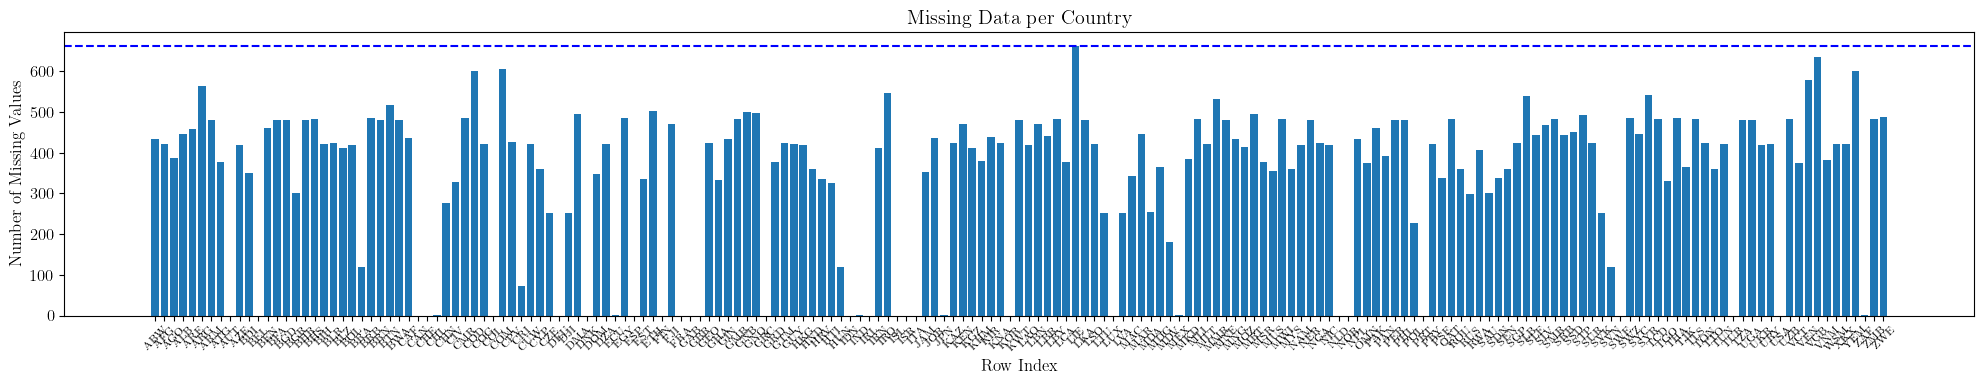

In [4]:
# missing data per line
missing_per_row = hcpi_m.isnull().sum(axis=1)

plt.figure(figsize=(20, 4))
plt.bar(missing_per_row.index, missing_per_row)
plt.xlabel("Row Index")
plt.ylabel("Number of Missing Values")
plt.title("Missing Data per Country")
plt.xticks(rotation=45, fontsize=8)
plt.axhline(y=hcpi_m.shape[1]-1, color='blue', linestyle='--', label='Number of Possible Observations')
plt.tight_layout()
plt.show()


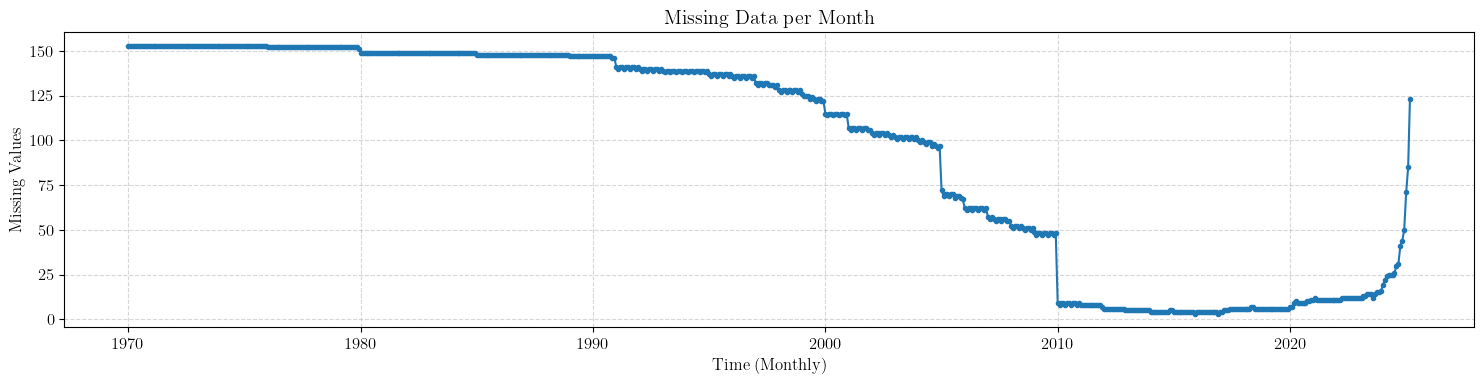

In [5]:
# missing data per column
time_cols = hcpi_m.columns[1:]
missing_per_month = hcpi_m[time_cols].isnull().sum()

plt.figure(figsize=(15, 4))
plt.plot(time_cols, missing_per_month.values, linestyle='-', marker='o', markersize=3)
plt.xlabel("Time (Monthly)")
plt.ylabel("Missing Values")
plt.title("Missing Data per Month")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

most of the missing data i would say is due to the fact that the data just starts being tracked from a certain date

i wonder if there is missing data after the first date, if so, maybe we should interpolate the data

lets check

In [6]:
def get_missing_data():
    results = {}
    for i, row in hcpi_m.iterrows():
        row_data = row[1:]

        results[i] = {
            "first": None,
            "last": None,
            "missing": None,
        }

        for col in hcpi_m.columns[1:]:

            # Check if the value is not NaN
            # and update the first and last columns accordingly
            if pd.notna(row[col]):
                results[i]["first"] = min(col, results[i]["first"]) if results[i]["first"] else col
                results[i]["last"] = max(col, results[i]["last"]) if results[i]["last"] else col
            
            # Check if the value is NaN
            # and update the missing columns accordingly
            else:
                if results[i]["first"] is not None:
                    if results[i]["missing"] is None:
                        results[i]["missing"] = [col]
                    else:
                        results[i]["missing"].append(col)
        
        # Make sure to not include missing values after the last value
        missing_filtered = []
        if results[i]["missing"]:
            for missing in results[i]["missing"]:
                if not missing > results[i]["last"]:
                    missing_filtered.append(missing)
            if missing_filtered != []:
                results[i]["missing"] = missing_filtered
            else:
                results[i]["missing"] = None
    
    return results

# Get the results
results = get_missing_data()
{k:len(results[k]["missing"]) for k,v in results.items() if results[k]["missing"] is not None}

{'BGR': 1, 'BLZ': 161, 'BRB': 2, 'GNB': 3, 'RUS': 30, 'SUR': 2, 'YEM': 11}

some countries have that problem, lets check each one by hand and maybe use interpolation, change the first date, etc.

- BGR (1 missing value)

In [7]:
results["BGR"]

{'first': Timestamp('1995-01-01 00:00:00'),
 'last': Timestamp('2025-03-01 00:00:00'),
 'missing': [Timestamp('2025-01-01 00:00:00')]}

In [8]:
hcpi_m.loc["BGR", pd.Timestamp("2024-11"):pd.Timestamp("2025-03")]

2024-11-01 00:00:00    9628.256655
2024-12-01 00:00:00    9666.817433
2025-01-01 00:00:00            NaN
2025-02-01 00:00:00    9920.101163
2025-03-01 00:00:00      9935.1779
Name: BGR, dtype: object

In [9]:
row = hcpi_m.loc["BGR"].iloc[1:]
value = row.astype(float).interpolate(method='linear').loc[pd.Timestamp("2025-01-01")]
hcpi_m.loc["BGR", pd.Timestamp("2025-01-01")] = value

print(f"Interpolated value for BGR on 2025-01-01: {hcpi_m.loc['BGR', pd.Timestamp('2025-01-01')]}")

Interpolated value for BGR on 2025-01-01: 9793.459298005415


- BLZ (161 missing values)

In [10]:
#hcpi_m.loc["BLZ"].to_csv("BLZ.csv")

# The problem is that the data is quarterly until 2011-01,
# the easiest fix is to set the start date to 2011-01

results["BLZ"]["first"], results["BLZ"]["last"]

(Timestamp('1990-11-01 00:00:00'), Timestamp('2025-02-01 00:00:00'))

In [11]:
hcpi_m.loc["BLZ", pd.Timestamp("2010-10"):pd.Timestamp("2011-02")]

2010-10-01 00:00:00          NaN
2010-11-01 00:00:00    94.409328
2010-12-01 00:00:00          NaN
2011-01-01 00:00:00    95.490717
2011-02-01 00:00:00    95.422967
Name: BLZ, dtype: object

In [12]:
hcpi_m.loc["BLZ", pd.Timestamp("1990-11"):pd.Timestamp("2010-12")] = None

- BRB (2 missing values)

In [13]:
results["BRB"]

{'first': Timestamp('2010-01-01 00:00:00'),
 'last': Timestamp('2024-11-01 00:00:00'),
 'missing': [Timestamp('2020-04-01 00:00:00'),
  Timestamp('2021-02-01 00:00:00')]}

In [14]:
hcpi_m.loc["BRB", pd.Timestamp("2020-02"):pd.Timestamp("2020-06")]

2020-02-01 00:00:00    90.278685
2020-03-01 00:00:00    90.417504
2020-04-01 00:00:00          NaN
2020-05-01 00:00:00    90.232412
2020-06-01 00:00:00    89.908501
Name: BRB, dtype: object

In [15]:
hcpi_m.loc["BRB", pd.Timestamp("2020-12"):pd.Timestamp("2021-04")]

2020-12-01 00:00:00    93.517797
2021-01-01 00:00:00    93.240159
2021-02-01 00:00:00          NaN
2021-03-01 00:00:00    91.435511
2021-04-01 00:00:00    90.926508
Name: BRB, dtype: object

In [16]:
row = hcpi_m.loc["BRB"].iloc[1:]
values = row.astype(float).interpolate(method='linear')
hcpi_m.loc["BRB", pd.Timestamp("2020-04-01")] = values.loc[pd.Timestamp("2020-04-01")]
hcpi_m.loc["BRB", pd.Timestamp("2021-02-01")] = values.loc[pd.Timestamp("2021-02-01")]

print(f"Interpolated value for BRB on 2020-04-01: {hcpi_m.loc['BRB', pd.Timestamp('2020-04-01')]}")
print(f"Interpolated value for BRB on 2021-02-01: {hcpi_m.loc['BRB', pd.Timestamp('2021-02-01')]}")

Interpolated value for BRB on 2020-04-01: 90.32495812395311
Interpolated value for BRB on 2021-02-01: 92.33783500837521


- GNB (3 missing values)

In [17]:
results["GNB"]

{'first': Timestamp('2010-01-01 00:00:00'),
 'last': Timestamp('2023-11-01 00:00:00'),
 'missing': [Timestamp('2023-05-01 00:00:00'),
  Timestamp('2023-06-01 00:00:00'),
  Timestamp('2023-07-01 00:00:00')]}

In [18]:
hcpi_m.loc["GNB", pd.Timestamp("2023-02"):pd.Timestamp("2023-10")]

2023-02-01 00:00:00    125.4
2023-03-01 00:00:00    125.5
2023-04-01 00:00:00    126.4
2023-05-01 00:00:00      NaN
2023-06-01 00:00:00      NaN
2023-07-01 00:00:00      NaN
2023-08-01 00:00:00    128.3
2023-09-01 00:00:00    126.9
2023-10-01 00:00:00    126.6
Name: GNB, dtype: object

In [19]:
row = hcpi_m.loc["GNB"].iloc[1:]
values = row.astype(float).interpolate(method='linear')
hcpi_m.loc["GNB", pd.Timestamp("2023-05-01"):pd.Timestamp("2023-07-01")] = values.loc[pd.Timestamp("2023-05-01"):pd.Timestamp("2023-07-01")]

hcpi_m.loc["GNB", pd.Timestamp("2023-02"):pd.Timestamp("2023-10")]

/opt/anaconda3/envs/CAA02/lib/python3.10/site-packages/pandas/core/indexing.py:2421: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  new_ix = Index(new_ix)


2023-02-01 00:00:00      125.4
2023-03-01 00:00:00      125.5
2023-04-01 00:00:00      126.4
2023-05-01 00:00:00    126.875
2023-06-01 00:00:00     127.35
2023-07-01 00:00:00    127.825
2023-08-01 00:00:00      128.3
2023-09-01 00:00:00      126.9
2023-10-01 00:00:00      126.6
Name: GNB, dtype: object

- RUS (30 missing values)

In [20]:
#hcpi_m.loc["RUS"].to_csv("RUS.csv")

# The problem is that after 2022-03, the only observations are in 2023-08 and 2024-11,
# so the easiest fix is to set the end date to 2022-03

results["RUS"]["first"], results["RUS"]["last"]

(Timestamp('1992-01-01 00:00:00'), Timestamp('2024-11-01 00:00:00'))

In [21]:
hcpi_m.loc["RUS", pd.Timestamp("2022-04"):pd.Timestamp("2024-11")] = None

- SUR (2 missing values)

In [22]:
results["SUR"]

{'first': Timestamp('2005-01-01 00:00:00'),
 'last': Timestamp('2025-02-01 00:00:00'),
 'missing': [Timestamp('2018-05-01 00:00:00'),
  Timestamp('2018-06-01 00:00:00')]}

In [23]:
hcpi_m.loc["SUR", pd.Timestamp("2018-02"):pd.Timestamp("2018-09")]

2018-02-01 00:00:00    132.6
2018-03-01 00:00:00    132.8
2018-04-01 00:00:00    133.1
2018-05-01 00:00:00      NaN
2018-06-01 00:00:00      NaN
2018-07-01 00:00:00    134.8
2018-08-01 00:00:00    135.8
2018-09-01 00:00:00    136.4
Name: SUR, dtype: object

In [24]:
row = hcpi_m.loc["SUR"].iloc[1:]
values = row.astype(float).interpolate(method='linear')
hcpi_m.loc["SUR", pd.Timestamp("2018-05-01"):pd.Timestamp("2018-06-01")] = values.loc[pd.Timestamp("2018-05-01"):pd.Timestamp("2018-06-01")]

hcpi_m.loc["SUR", pd.Timestamp("2018-02"):pd.Timestamp("2018-09")]

/opt/anaconda3/envs/CAA02/lib/python3.10/site-packages/pandas/core/indexing.py:2421: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  new_ix = Index(new_ix)


2018-02-01 00:00:00         132.6
2018-03-01 00:00:00         132.8
2018-04-01 00:00:00         133.1
2018-05-01 00:00:00    133.666667
2018-06-01 00:00:00    134.233333
2018-07-01 00:00:00         134.8
2018-08-01 00:00:00         135.8
2018-09-01 00:00:00         136.4
Name: SUR, dtype: object

- YEM (11 missing values)

In [25]:
#hcpi_m.loc["YEM"].to_csv("YEM.csv")

# The problem is that after 2014-12, the only observation is in 2015-12,
# the easiest fix is to set the end date to 2014-12

results["YEM"]["first"], results["YEM"]["last"]

(Timestamp('2010-01-01 00:00:00'), Timestamp('2015-12-01 00:00:00'))

In [26]:
hcpi_m.loc["YEM", pd.Timestamp("2015-12")] = None

lets check if now its all fixed

In [27]:
results = get_missing_data()
{k:len(results[k]["missing"]) for k,v in results.items() if results[k]["missing"] is not None}

{}

## Time Window Analysis

we should analyse the best time frame to use for the analysis, lets check the nans distribution based on the that

In [28]:
def window_stats(start=None, end=None):
    if start is None:
        start = "1970-01"
    if end is None:
        end = "2025-03"

    start = pd.Timestamp(start)
    end = pd.Timestamp(end)

    data = hcpi_m.loc[:, start:end]

    # overall nan stats
    nonnulls = data.notnull().sum(axis=1).sum()
    nulls = data.isnull().sum(axis=1).sum()
    total = nonnulls + nulls

    print(f"Out of {total} values, {nonnulls} ({nonnulls/total:.2f}) are non-null and {nulls} ({nulls/total:.2f}) are null.")

    # overall nan stats per country
    nonnulls_per_country = data.notnull().sum(axis=1)
    nulls_per_country = data.isnull().sum(axis=1)
    total_per_country = int((nonnulls_per_country + nulls_per_country).mean())

    # overall nan stats per month
    nonnulls_per_month = data.notnull().sum(axis=0)
    nulls_per_month = data.isnull().sum(axis=0)
    total_per_month = int((nonnulls_per_month + nulls_per_month).mean())

    fig, axes = plt.subplots(1, 2, figsize=(20, 4))

    # histogram of non-null values per country
    axes[0].hist(nonnulls_per_country, bins=20, color='blue', alpha=0.7)
    axes[0].set_xlabel("Number of Non-Null Values (Bigger is Better)")
    axes[0].set_ylabel("Frequency")
    axes[0].set_title("per Country")

    # histogram of non-null values per month
    axes[1].hist(nonnulls_per_month, bins=20, color='green', alpha=0.7)
    axes[1].set_xlabel("Number of Non-Null Values (Bigger is Better)")
    axes[1].set_ylabel("Frequency")
    axes[1].set_title("per Month")

    plt.tight_layout()
    plt.show()

1970-01 to 2025-03
Out of 122655 values, 58551 (0.48) are non-null and 64104 (0.52) are null.


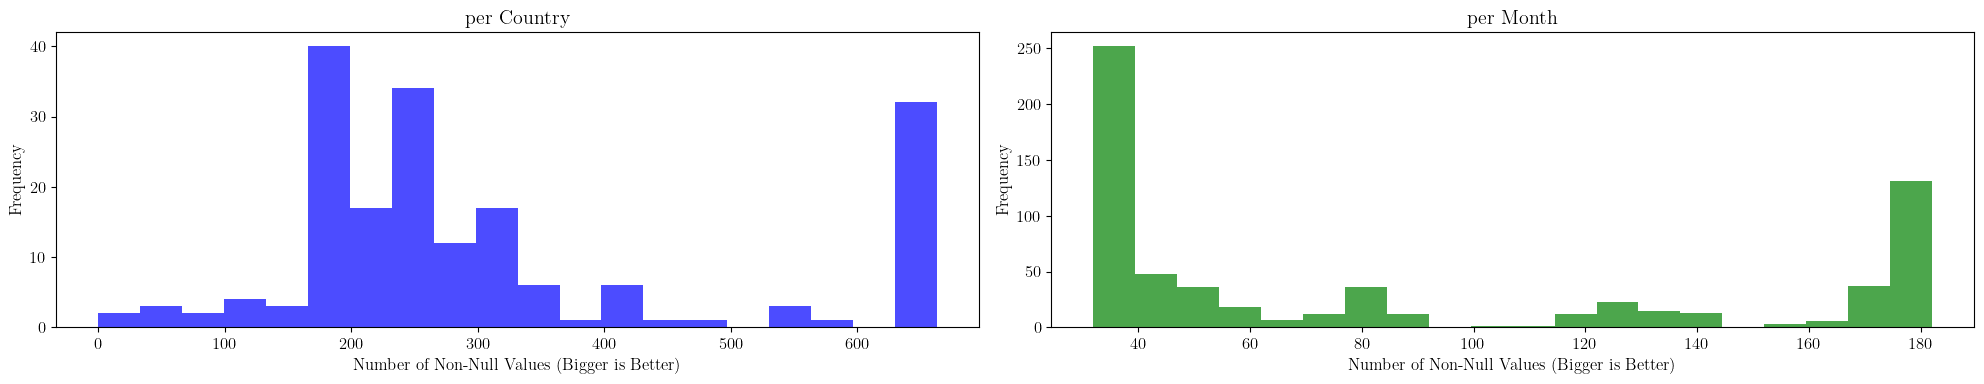


------------------------------

2000-01 to 2024-12
Out of 55500 values, 44143 (0.80) are non-null and 11357 (0.20) are null.


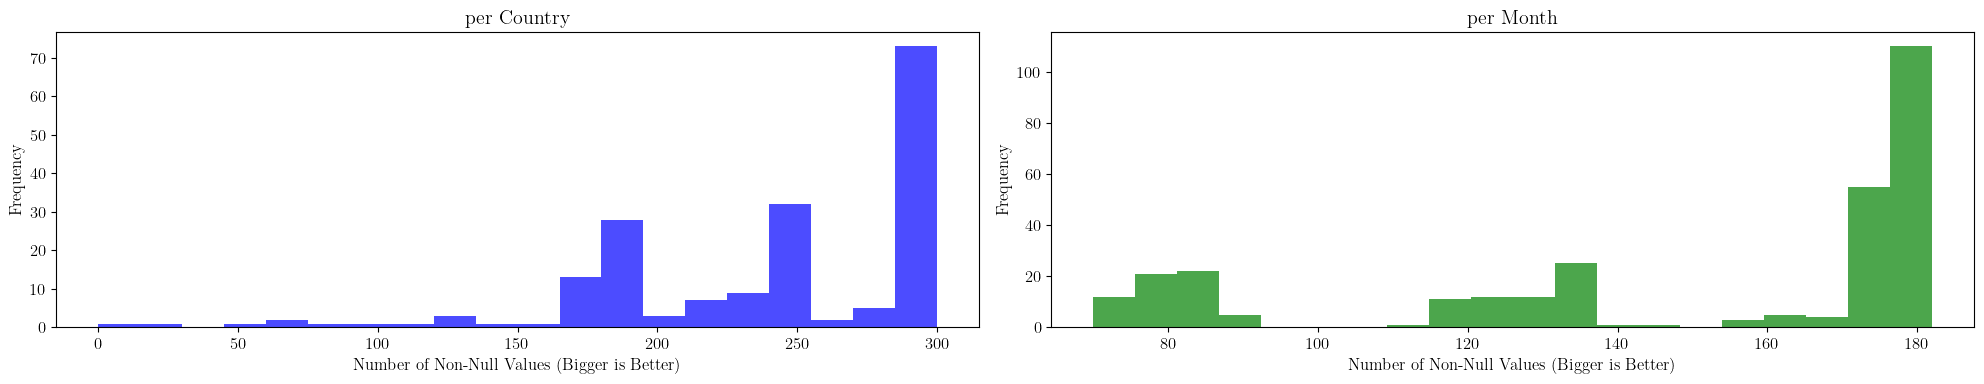


------------------------------

2010-01 to 2020-12
Out of 24420 values, 23624 (0.97) are non-null and 796 (0.03) are null.


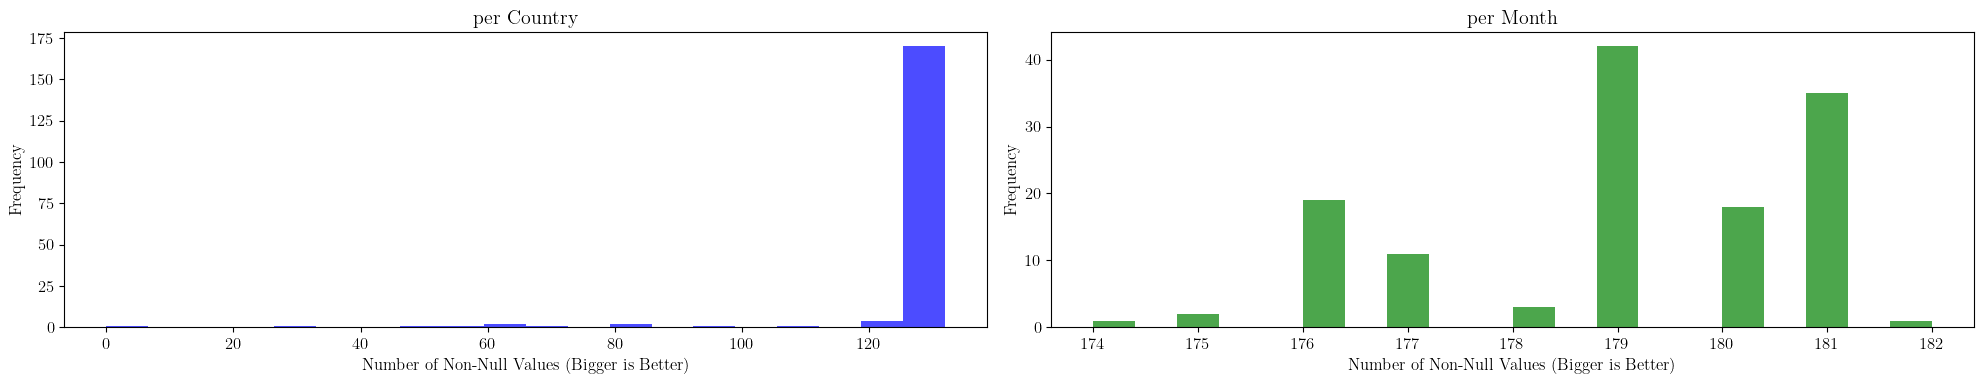

In [29]:
print("1970-01 to 2025-03")
window_stats("1970-01", "2025-03")

print("\n" + "-"*30 + "\n")

print("2000-01 to 2024-12")
window_stats("2000-01", "2024-12")

print("\n" + "-"*30 + "\n")

print("2010-01 to 2020-12")
window_stats("2010-01", "2020-12")

lets try to over layer like the time frame of each country

/var/folders/sz/96b_h5gn3y33k0c7jsvrstmm0000gn/T/ipykernel_18245/2311504363.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coverage.append((row[0], start, end))


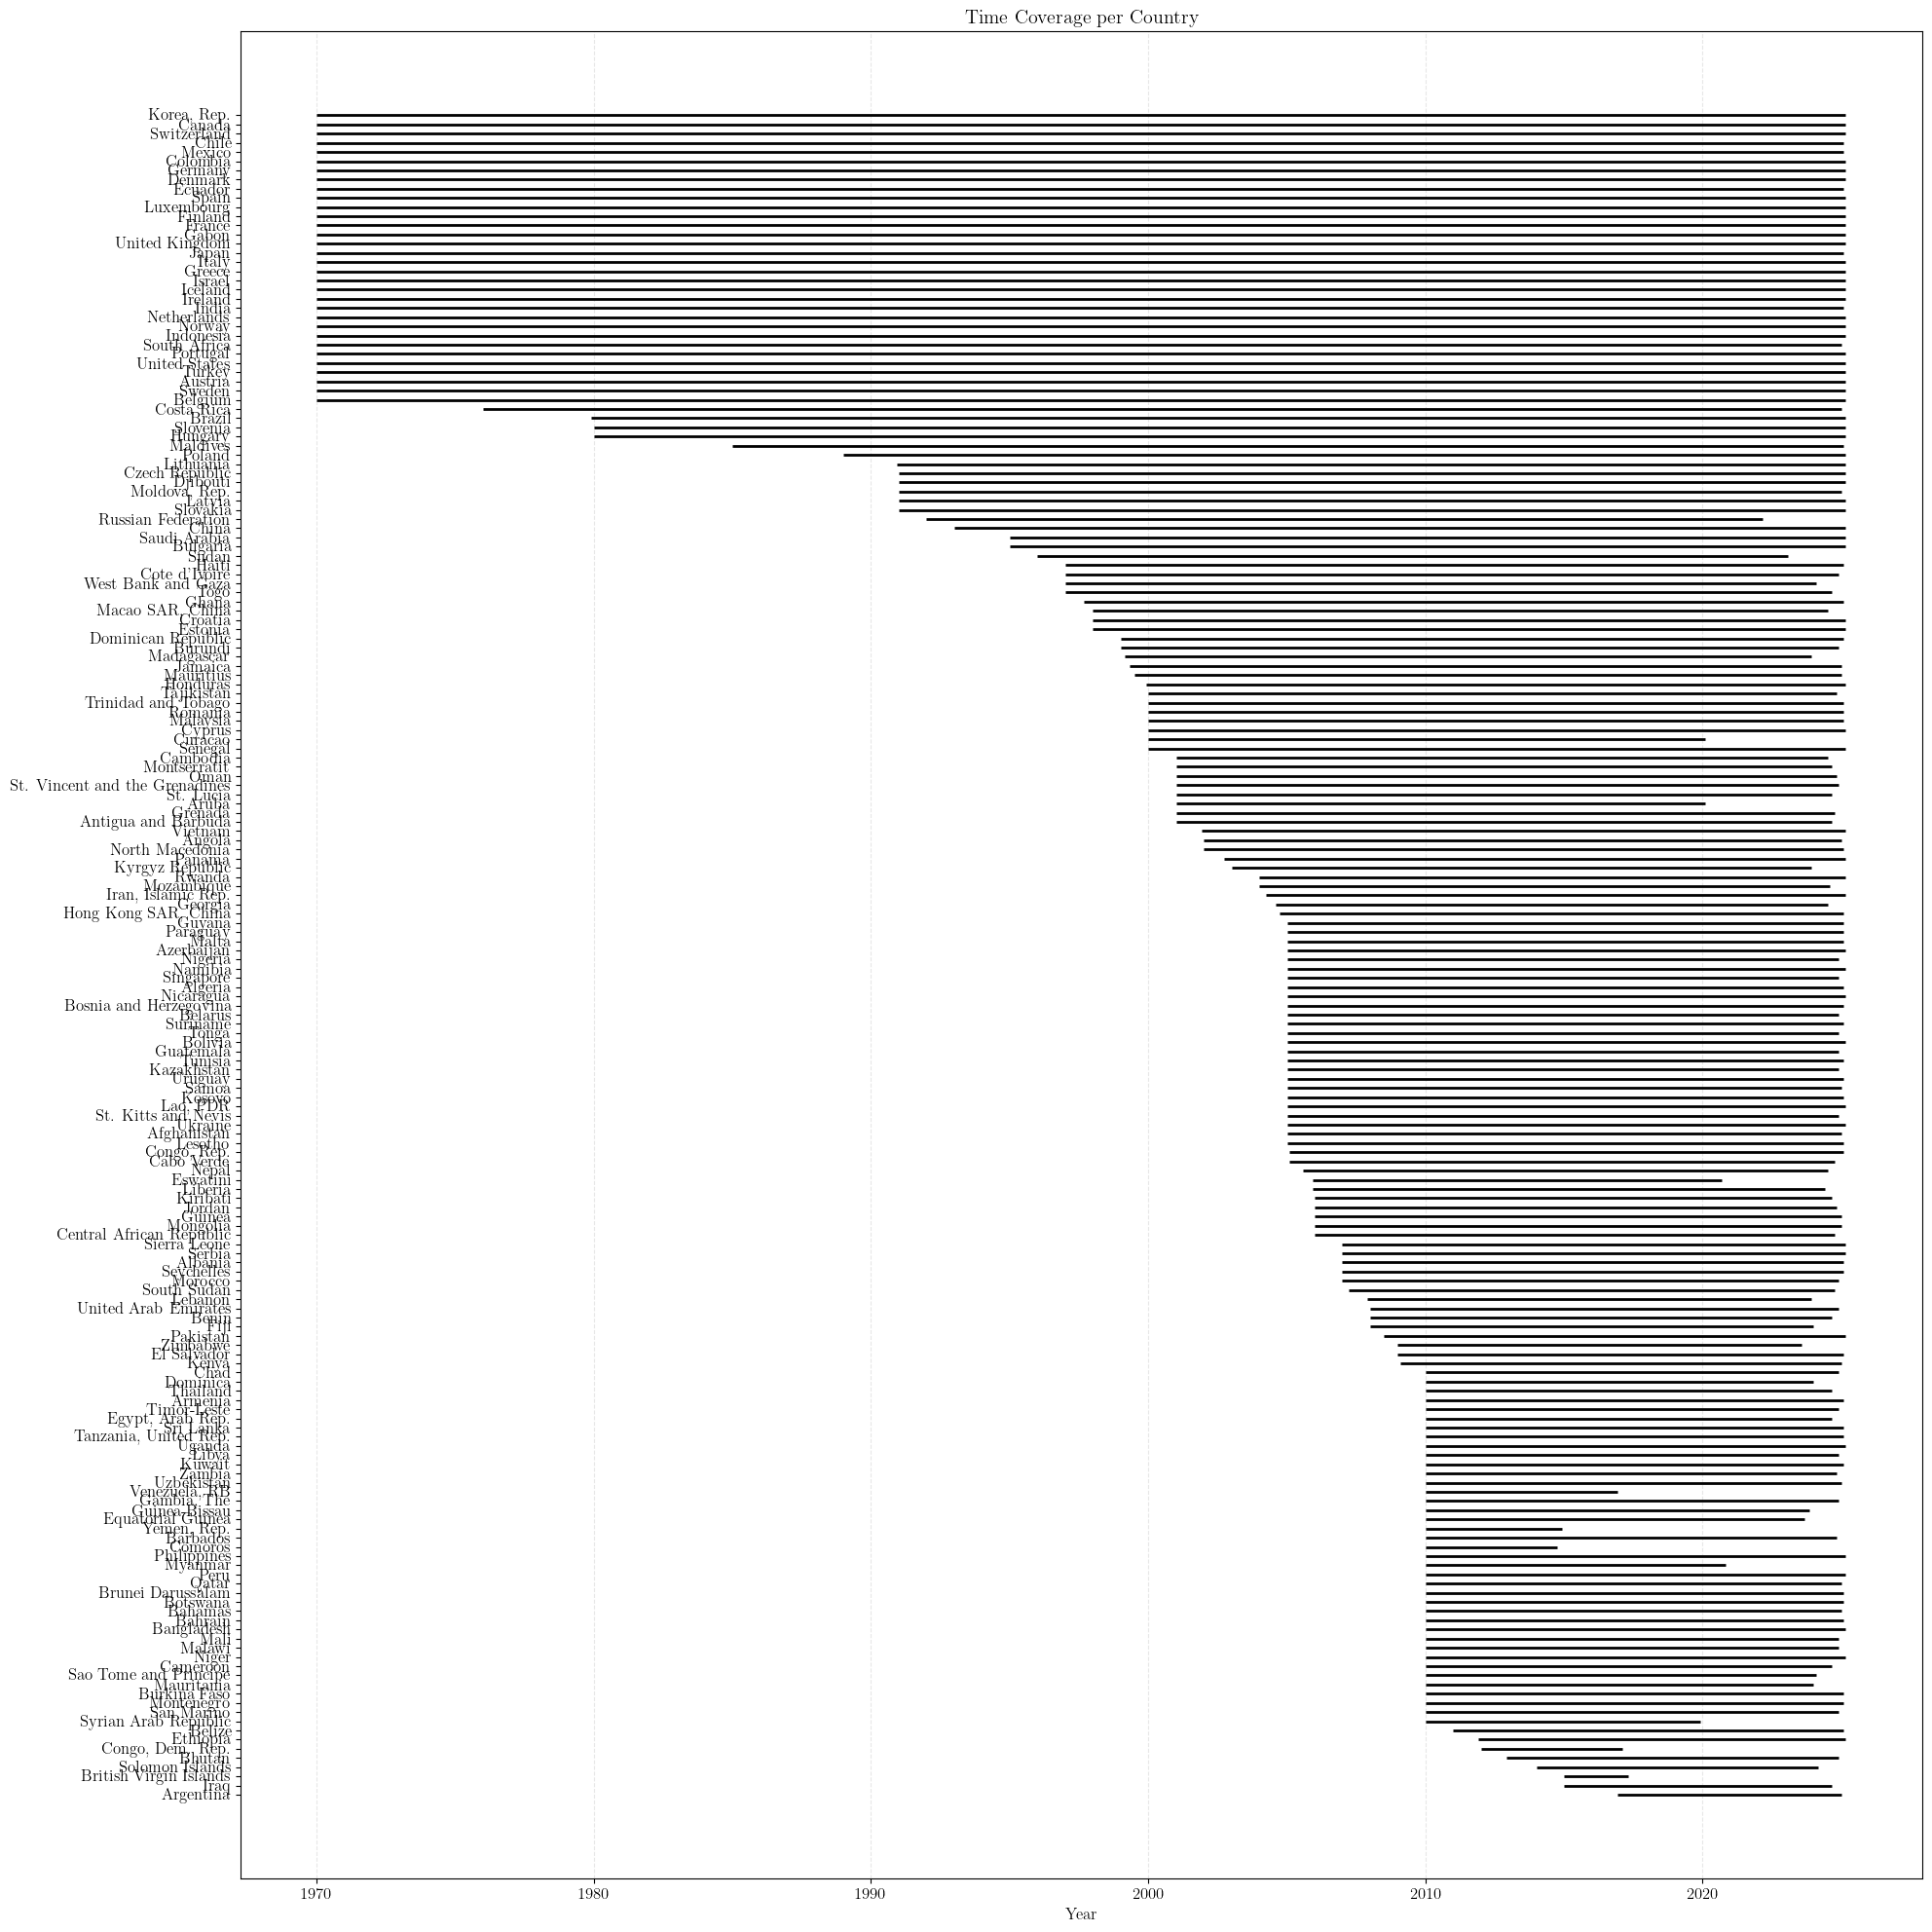

In [30]:
# get the start and end dates for each country
coverage = []
for i, row in hcpi_m.iterrows():
    ts = row[hcpi_m.columns[1:]]
    valid = ts.notna()
    if valid.any():
        start = ts[valid].index[0]
        end = ts[valid].index[-1]
        coverage.append((row[0], start, end))

coverage_df = pd.DataFrame(coverage, columns=["Country", "Start", "End"])
coverage_df = coverage_df.sort_values("Start").reset_index(drop=True)

# plot all countries as horizontal lines
fig, ax = plt.subplots(figsize=(20,20))

for i, row in coverage_df.iterrows():
    ax.hlines(y=i, xmin=row["Start"], xmax=row["End"], color="black", linewidth=2)

# yaxis: country names
ax.set_yticks(range(len(coverage_df)))
ax.set_yticklabels(coverage_df["Country"])

ax.set_xlabel("Year")
ax.set_title("Time Coverage per Country")
ax.invert_yaxis()  # country at top = earliest start
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

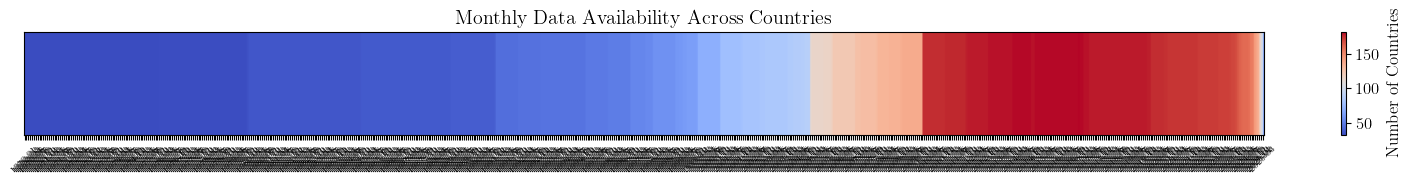

In [31]:
# count non-null values per month
non_null_counts = hcpi_m.iloc[:, 1:].notna().sum(axis=0)
non_null_counts.index = hcpi_m.columns[1:]

# reshape to 2D array (1 x N)
data = non_null_counts.values.reshape(1, -1)

fig, ax = plt.subplots(figsize=(16, 2))
im = ax.imshow(data, aspect="auto", cmap="coolwarm")

# axis
ax.set_xticks(np.arange(len(non_null_counts)))
ax.set_xticklabels([d.strftime("%Y-%m") for d in non_null_counts.index], rotation=45, fontsize=6)
ax.get_yaxis().set_visible(False)

# colorbar
cbar = plt.colorbar(im, ax=ax, orientation="vertical")
cbar.set_label("Number of Countries")

plt.title("Monthly Data Availability Across Countries")
plt.tight_layout()
plt.show()

# Save the cleaned data

save a mapping of the countries codes to their names so we can drop the country name column to only keep the data that matters for later on

In [32]:
unique_indexes = hcpi_m.index.unique().tolist()
print(f"Are all indxes unique? {len(unique_indexes) == len(hcpi_m.index)}")

unique_countries = hcpi_m.index.unique().tolist()
print(f"Are all countries unique? {len(unique_countries) == len(hcpi_m.index)}")

# map each index to a country
country_map = {}
for i, row in hcpi_m.iterrows():
    country_map[i] = row["Country"]

if False:
    with open("data/countries.json", "w") as f:
        json.dump(country_map, f, indent=4)
print(f"Countries saved to data/countries.json")

Are all indxes unique? True
Are all countries unique? True
Countries saved to data/countries.json


drop the country name column and reestructure the data to have the dates as the index and the countries as columns

In [33]:
hcpi_m = hcpi_m.drop(columns=["Country"])
hcpi_m = hcpi_m.T
hcpi_m.index.name = None
hcpi_m.columns.name = None

save the cleaned data to a parquet

In [34]:
if False:
    hcpi_m.to_parquet("data/hcpi_m.parquet", index=True)

In [35]:
hcpi_m.head(3)

,ABW,AFG,AGO,ALB,ARE,ARG,ARM,ATG,AUT,AZE,...,VCT,VEN,VGB,VNM,WSM,XKX,YEM,ZAF,ZMB,ZWE
1970-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.48557,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.750407,NaN,NaN
1970-02-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.46568,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.750407,NaN,NaN
1970-03-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.48557,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.750407,NaN,NaN
